<font color='blue'> **08 __________________________________ GeostatsPy_kriging** </font> 

In [ ]:
import os; import sys ; from pathlib import Path    ; _R = Path("_R")   ; _R.mkdir(exist_ok=True); TA = Path('_R/08_GeostatsPy_kriging_'); TA.mkdir(exist_ok=True)
import numpy as np    ; import pandas as pd ; import matplotlib.pyplot as plt   # sys.path.append('E:/15_REPOS/05_Working/11e_Kriging_Beta/Guy') ; from g1 import #def
import geostatspy.GSLIB as GSLIB   ; import geostatspy.geostats as geostats     ; import geostatspy ; cmap = plt.cm.inferno ; plt.rc('axes', axisbelow=True) ; ignore_warnings = True
if ignore_warnings == True:                                   
    import warnings ; warnings.filterwarnings('ignore')
REF1 = Path('E:/15_REPOS/02_Beta-Me/data/Krig/GeostatsPy')  
fraction_data = 0.2; df = pd.read_csv(REF1/'sample_data_MV_biased.csv')                   ;df = df.drop(columns=['Unnamed: 0','Unnamed: 0.1'], axis=1)
if fraction_data < 1.0:      df = df.sample(frac = fraction_data,replace = False,random_state = 73073) 
df = df.reset_index()      ; df['LogPerm'] = np.log(df['Perm'].values)                   #;df.head()

In [2]:
df.iloc[:,4:8].describe().transpose()                                     

,count,mean,std,min,25%,50%,75%,max
Porosity,74.0,0.125834,0.031093,0.062169,0.102895,0.126264,0.148840,0.204587
Perm,74.0,73.040451,214.164084,0.300430,2.081215,10.385010,50.841029,1665.384124
AI,74.0,4853.532434,1100.612966,1981.177309,4074.882537,4722.574276,5542.402947,7561.250336
LogPerm,74.0,2.358329,2.086617,-1.202542,0.731083,2.339396,3.928694,7.417811


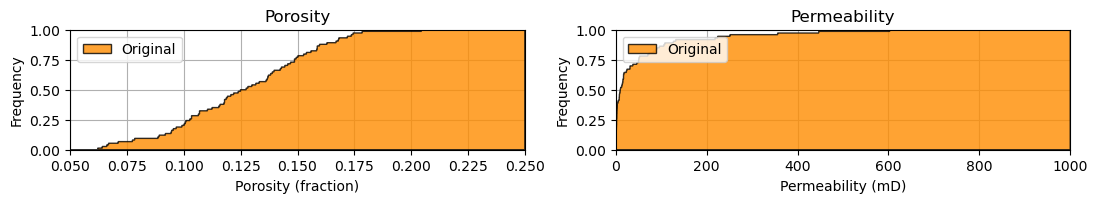

In [3]:
fig = plt.figure(figsize=(5,1))                                               ; BIM1=np.linspace(0.0,0.25,1000)             ;BIM2=np.linspace(0.0,1000.0,100000)     ; SF="stepfilled"
plt.subplot(121)       ;plt.hist(df['Porosity'], facecolor='darkorange'       , bins=BIM1,histtype=SF,alpha=0.8,density=True,cumulative=True,edgecolor='black',label='Original')
plt.xlim([0.05,0.25])  ;plt.ylim([0,1.0]) ; plt.xlabel('Porosity (fraction)') ; plt.ylabel('Frequency'); plt.title('Porosity')        ; plt.legend(loc='upper left')  ; plt.grid(True)
plt.subplot(122)       ;plt.hist(df['Perm'], facecolor='darkorange'           , bins=BIM2,histtype=SF,alpha=0.8,density=True,cumulative=True,edgecolor='black',label='Original')
plt.xlim([0.0,1000.0]) ;plt.ylim([0,1.0]) ; plt.xlabel('Permeability (mD)')   ; plt.ylabel('Frequency'); plt.title('Permeability')    ; plt.legend(loc='upper left')  ; plt.grid(True)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.2, wspace=0.2      , hspace=0.3) ; plt.show()

In [4]:
%%capture   
perm_vrange_maj = 250; perm_vrange_min = 100   ;perm_vazi = 150.0  ;perm_vrel_nugget = 0.0   # variogram ranges | major direction | nugget effect
por_vrange_maj2 = 150; por_vrange_min2 = 50    ;por_vazi2 = 150.0  ;por_vrel_nugget2 = 0.0   ; ME2 = np.average(df['Perm'].values)          ; SI2 = np.var(df['Perm'].values) 
por_vrange_maj1 = 250; por_vrange_min1 = 100   ;por_vazi1  = 150.0 ;por_vrel_nugget1 = 0.0   ; ME1 = np.average(df['Porosity'].values)      ; SI1 = np.var(df['Porosity'].values)                      
radius = 600   ;nxdis = 1; nydis = 1   ;ndmin = 0; ndmax = 10                                ; pormin=0.05 ;pormax=0.22 ;permmin=0.0;permmax=700.0   ;xsiz=10;ysiz=10;nx=100;ny=100;xmn=5;ymn=5 

perm_vario = GSLIB.make_variogram (nug=perm_vrel_nugget*SI2  ,nst=1,it1=1,cc1=(1.0-perm_vrel_nugget)*SI2 ,azi1=perm_vazi ,hmaj1=perm_vrange_maj ,hmin1=perm_vrange_min)
por_vario2 = GSLIB.make_variogram (nug=por_vrel_nugget2*SI1  ,nst=1,it1=1,cc1=(1.0-por_vrel_nugget2)*SI1 ,azi1=por_vazi2 ,hmaj1=por_vrange_maj2 ,hmin1=por_vrange_min2) 
por_vario1 = GSLIB.make_variogram (nug=por_vrel_nugget1*SI1  ,nst=1,it1=1,cc1=(1.0-por_vrel_nugget1)*SI1 ,azi1=por_vazi1 ,hmaj1=por_vrange_maj1 ,hmin1=por_vrange_min1) 

perm_kmap, perm_vmap     = geostats.kb2d(df,'X','Y','Perm'    ,permmin,permmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,ndmin,ndmax,radius,0,ME2,perm_vario) ; perm_kmap[perm_kmap<0.0001]=0.0001
por_SK_kmap, por_vmap    = geostats.kb2d(df,'X','Y','Porosity',pormin ,pormax ,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,ndmin,ndmax,radius,0,ME1,por_vario2) ; print(perm_kmap.shape)
por_OK_kmap, por_OK_vmap = geostats.kb2d(df,'X','Y','Porosity',pormin ,pormax ,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,ndmin,ndmax,radius,1,ME1,por_vario2)     # ktype = 0 | 1
por_kmap, por_vmap       = geostats.kb2d(df,'X','Y','Porosity',pormin ,pormax ,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,ndmin,ndmax,radius,0,ME1,por_vario1)     # simple    | ordinary Krig 

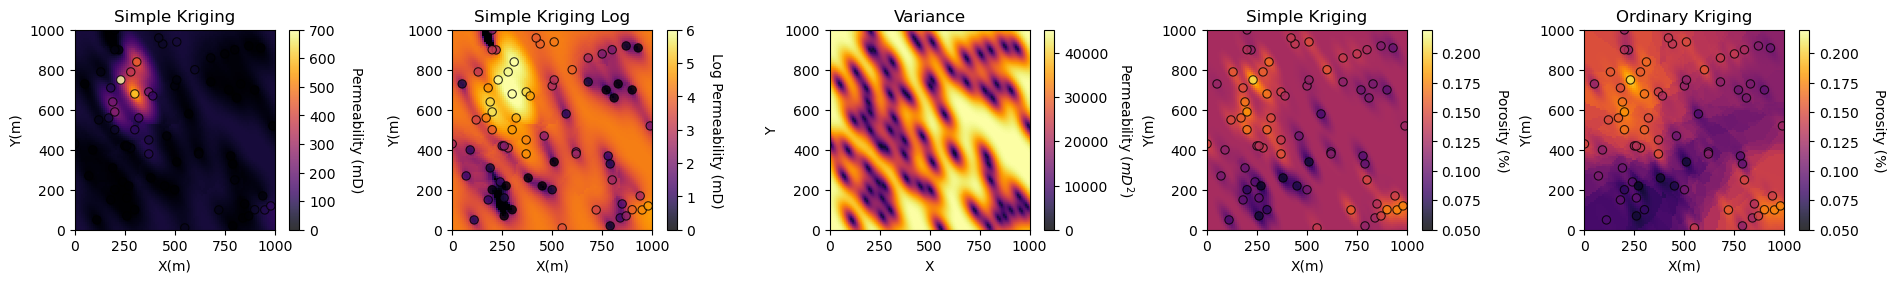

In [5]:
fig = plt.figure(figsize=(9,2))                                                                  ;xmin=0.0 ;xmax=1000.0   ;ymin=0.0 ;ymax=1000.0    
plt.subplot(151);GSLIB.locpix_st   (perm_kmap        ,xmin,xmax,ymin,ymax,xsiz,permmin,permmax,df        ,'X','Y','Perm'       ,'Simple Kriging'    ,'X(m)','Y(m)','Permeability (mD)',cmap)
plt.subplot(152);GSLIB.locpix_st   (np.log(perm_kmap),xmin,xmax,ymin,ymax,xsiz,0.0,6.0        ,df        ,'X','Y','LogPerm'    ,'Simple Kriging Log','X(m)','Y(m)','Log Permeability (mD)',cmap)
plt.subplot(153);GSLIB.pixelplt_st (perm_vmap        ,xmin,xmax,ymin,ymax,xsiz,0.0,SI2        ,'Variance','X','Y',r'Permeability ($mD^2$)',cmap)
plt.subplot(154);GSLIB.locpix_st   (por_SK_kmap      ,xmin,xmax,ymin,ymax,xsiz,pormin,pormax  ,df        ,'X','Y','Porosity'   ,'Simple Kriging'    ,'X(m)','Y(m)','Porosity (%)',cmap)
plt.subplot(155);GSLIB.locpix_st   (por_OK_kmap      ,xmin,xmax,ymin,ymax,xsiz,pormin,pormax  ,df        ,'X','Y','Porosity'   ,'Ordinary Kriging'  ,'X(m)','Y(m)','Porosity (%)',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.3, hspace=0.3); plt.show()
# shorten the variogram model range to exagerate the difference between simple and ordinary kriging, i.e., with esitmates outside variogram range from any data

In [6]:
#fig = plt.figure(figsize=(5,2))                                         
#plt.subplot(121) ; GSLIB.locmap_st(df,'X','Y','Porosity',0,1000,0,1000  ,pormin,pormax,'Porosity - All Facies','X (m)','Y (m)','Nscore Porosity',cmap)
#plt.subplot(122) ; GSLIB.locmap_st(df,'X','Y','Perm',0,1000,0,1000      ,permmin,permmax,'Permeability - All Facies','X (m)','Y (m)','Nscore Permeability',cmap)
#plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.3, hspace=0.3); plt.show()

In [7]:
#fig = plt.figure(figsize=(5,2))    # POR | PER
#plt.subplot(121) ; GSLIB.locpix_st  (por_kmap,xmin,xmax,ymin,ymax,xsiz,pormin,pormax,df,'X','Y','Porosity','Simple Kriging','X(m)','Y(m)','Porosity (%)',cmap)
#plt.subplot(122) ; GSLIB.pixelplt_st(por_vmap,xmin,xmax,ymin,ymax,xsiz,0.0,SI1,'Kriging Variance','X(m)','Y(m)',r'Porosity ($\%^2$)',cmap)
#plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.3, hspace=0.3); plt.show()